# Network Analysis Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import networkx as nx
from pyvis.network import Network
import copy

### Importing & Cleaning the data

In [2]:
df_scientist = pd.read_csv("scientists_collab_pids_cleared.csv")
df_scientist.head()

,name,country,institution,dblp,expertise,pid
0,nicolas anciaux,france,inria,https://dblp.uni-trier.de/pers/a/Anciaux:Nicol...,NaN,00-1107
1,peifeng li,china,"soochow university, china",https://dblp.org/pers/l/Li:Peifeng.html,NaN,00-1996
2,kalpa gunaratna,united states,samsung research,https://dblp.org/pers/g/Gunaratna:Kalpa.html,NaN,00-9080
3,rada chirkova,united states,nc state university,https://dblp.org/pers/c/Chirkova:Rada.html,NaN,01-3589
4,mohammad dashti,united states,mongodb,https://dblp.org/pid/01/4316-1.html,NaN,01-4316-1


In [3]:
scientists = {}
for i in tqdm(range(len(df_scientist))):
    pid = df_scientist.at[i, 'pid']
    scientists[pid] = {
        'name': df_scientist.at[i, 'name'],
        'country': df_scientist.at[i, 'country'],
        'institution': df_scientist.at[i, 'institution']
    }

100%|██████████| 1061/1061 [00:00<00:00, 127311.02it/s]


In [4]:
df_papers = pd.read_csv("papers_cleaned.csv")
df_papers.head()

,Title,Year,DOI,Authors,file
0,IDoFew: Intermediate Training Using Dual-Clust...,2024,https://doi.org/10.48550/arXiv.2401.04025,['94-10440'],94-10440.xml
1,CLEFT: Contextualised Unified Learning of User...,2023,https://doi.org/10.1109/ACCESS.2023.3245982,['94-10440'],94-10440.xml
2,Graph-Aware Deep Fusion Networks for Online Sp...,2023,https://doi.org/10.1109/TCSS.2022.3189813,['94-10440'],94-10440.xml
3,NLP-Crowdsourcing Hybrid Framework for Inter-R...,2023,https://doi.org/10.1109/THMS.2023.3319290,['94-10440'],94-10440.xml
4,Topics in Contextualised Attention Embeddings.,2023,https://doi.org/10.1007/978-3-031-28238-6_15,['94-10440'],94-10440.xml


In [5]:
df_papers.at[i, 'Authors']

"['06-900-1', '116-1678']"

In [6]:
def str_to_list(a: str) -> list:
    a = a[1: -1]  # To remove the brackets []
    a_list = a.split(",")
    return [author.strip()[1: -1] for author in a_list]  # Removing the brackets and any spaces

print(str_to_list(df_papers.at[0, "Authors"]))
print(str_to_list(df_papers.at[273, "Authors"]))

['94-10440']
['40-6300', 's-IonStoica', '36-2133']


In [7]:
# Removing all papers with only 1 author (there were other authors but they were not part of the set given)
authors_list = []
yearwise_author_list = {}
for i in tqdm(range(len(df_papers))):
    author_str = df_papers.at[i, 'Authors']
    if "," in author_str:
        authors_collab = str_to_list(author_str)
        authors_list.append(authors_collab)
        year = df_papers.at[i, 'Year']
        if year in yearwise_author_list:
            yearwise_author_list[year].append(authors_collab)
        else:
            yearwise_author_list[year] = [authors_collab]

  0%|          | 0/101698 [00:00<?, ?it/s]

100%|██████████| 101698/101698 [00:00<00:00, 478445.48it/s]


Variables created:  
1) scientists: dict - Key is pid and value is a dict with all relevant scientist data
2) authors_list: list - A list of authors that have colaborated with each other (Only has collaborations not single papers)
3) yearwise_author_list: dict - The author_lists for each (key is year)

### Creating the Network
We use an Adjascency List as the network is very sparse and this will save space as compared to the Adjascency Matrix

In [8]:
network = {}

for author_collab in tqdm(authors_list):
    for i in range(len(author_collab)):
        for j in range(len(author_collab)):
            if i == j:
                continue
            if author_collab[i] in network:
                if author_collab[j] in network[author_collab[i]]:
                    network[author_collab[i]][author_collab[j]] += 1
                else:
                    network[author_collab[i]][author_collab[j]] = 1
            else:
                network[author_collab[i]] = {author_collab[j]: 1}

100%|██████████| 20163/20163 [00:00<00:00, 518571.95it/s]


In [12]:
# Saving the network as a json file
with open('network.json', 'w') as fp:
    json.dump(network, fp, indent=4)

### Visualise the network

In [9]:
# Create pandas edge list
temp_df_list = []
for node, neighbours in tqdm(network.items()):
    for neighbour, weight in neighbours.items():
        temp_df_list.append({
            'Source': node,
            'Destination': neighbour,
            'Weight': weight
        })

df_network_edgelist = pd.DataFrame(temp_df_list) 

100%|██████████| 993/993 [00:00<00:00, 279095.62it/s]


In [10]:
G = nx.from_pandas_edgelist(df_network_edgelist, source='Source', target='Destination', edge_attr='Weight')

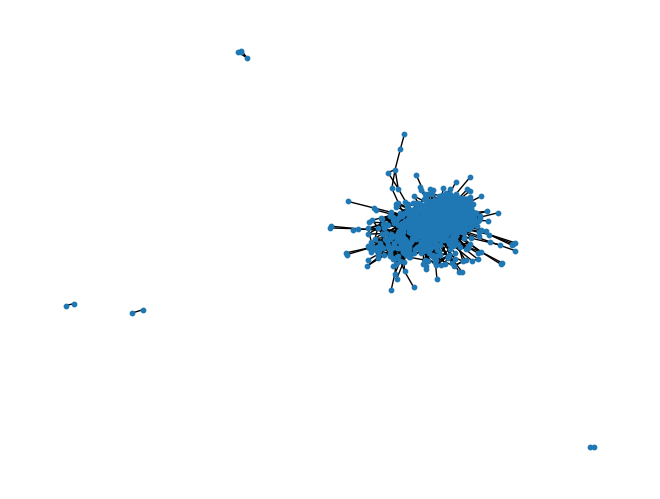

In [11]:
nx.draw_spring(G, node_size=10)

In [21]:
net = Network(notebook=True)
net.from_nx(G)

> Network too big to visualise effectively. Can check out colab_network.html (but it will take a while to load)

### Network Analysis

##### Degree Distribution

In [12]:
degree_dict = {node: len(vals) for node, vals in network.items()}
degree_distribution = list(degree_dict.values())
print(f"Degree Distribution Statistics:\n{pd.Series(degree_distribution).describe()}")
print(f"\nN={len(network)}")

Degree Distribution Statistics:
count    993.000000
mean      16.338369
std       17.865207
min        1.000000
25%        4.000000
50%       10.000000
75%       22.000000
max      101.000000
dtype: float64

N=993


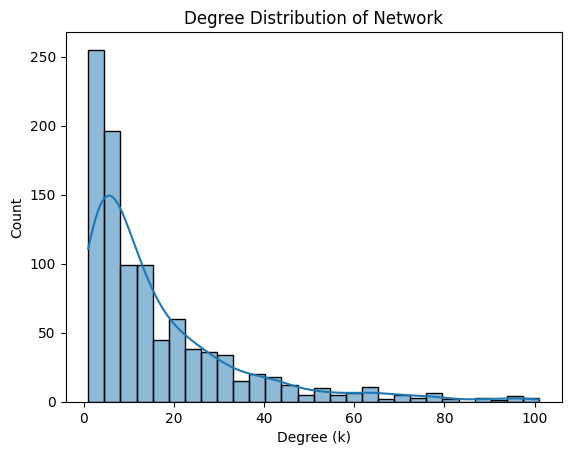

In [13]:
sns.histplot(data=degree_distribution, kde=True)
plt.title('Degree Distribution of Network')
plt.xlabel('Degree (k)')
plt.show()

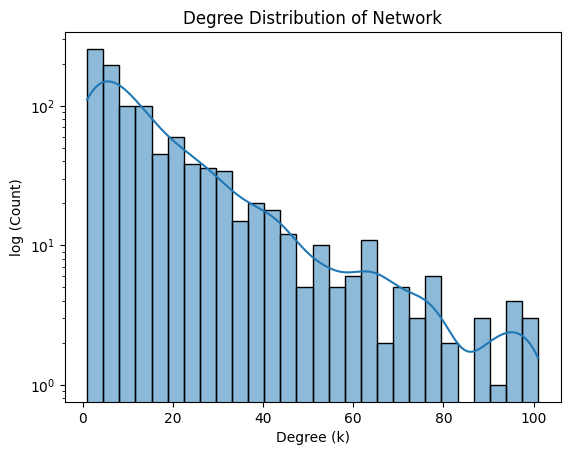

In [14]:
sns.histplot(data=degree_distribution, kde=True)
plt.title('Degree Distribution of Network')
plt.xlabel('Degree (k)')
plt.yscale("log")
plt.ylabel("log (Count)")
plt.show()

> This is resembling the characteristics of a scale-free network

##### EigenVector Centrality

In [15]:
eigenvector_centrality = {node: 1 for node in network.keys()}

for i in tqdm(range(30)):
    eigenvector_centrality_2 = {}
    for node, neighbours in network.items():
        eigenvector_centrality_2[node] = sum([eigenvector_centrality[neighbour] for neighbour in neighbours])

    max_value = max(eigenvector_centrality_2.values())
    eigenvector_centrality = {node: (value / max_value) for node, value in eigenvector_centrality_2.items()}

100%|██████████| 30/30 [00:00<00:00, 768.36it/s]


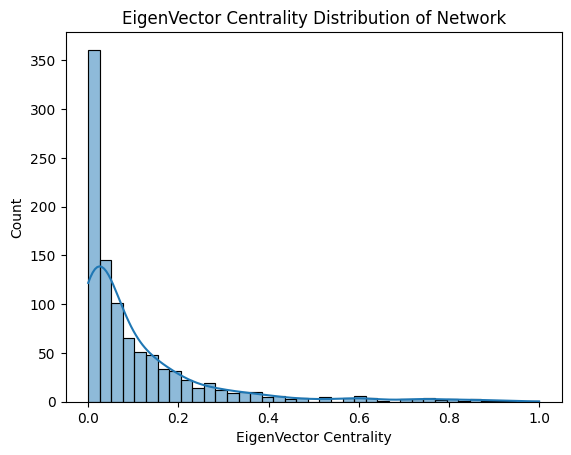

EigenVector Centrality Distribution Statistics:
count    9.930000e+02
mean     1.099738e-01
std      1.615304e-01
min      1.601191e-49
25%      1.049301e-02
50%      4.831554e-02
75%      1.393206e-01
max      1.000000e+00
dtype: float64


In [16]:
sns.histplot(data=list(eigenvector_centrality.values()), kde=True)
plt.title('EigenVector Centrality Distribution of Network')
plt.xlabel('EigenVector Centrality')
plt.show()

print(f"EigenVector Centrality Distribution Statistics:\n{pd.Series(eigenvector_centrality.values()).describe()}")

##### Clustering Coefficient

In [17]:
clustering_coefficient = {}

for node, neighbours in tqdm(network.items()):
    neighbour_connections = 0
    neighbours_set = set(neighbours.keys())
    for neighbour in neighbours_set:
        neighbour_connections += len(set(network[neighbour].keys()).intersection(neighbours_set))
    clustering_coefficient[node] = neighbour_connections / (len(neighbours_set) * (len(neighbours_set) + 1))  # No multiple by 2 as im counting each edge twice

print(f"Average Clustering Coefficient of the network = <C> = {sum(clustering_coefficient.values()) / len(clustering_coefficient)}")

100%|██████████| 993/993 [00:00<00:00, 29289.54it/s]

Average Clustering Coefficient of the network = <C> = 0.2341408434907006


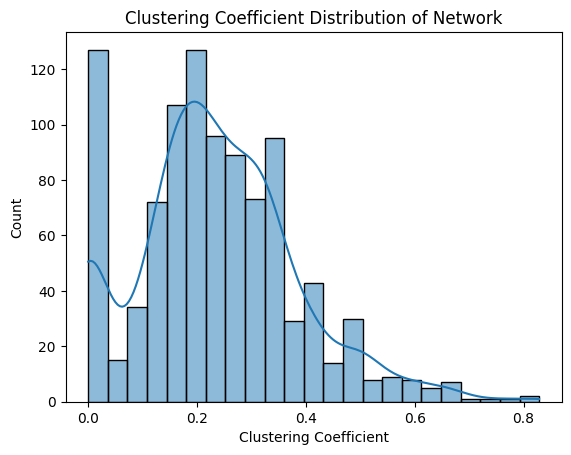

Clustering Coefficient Distribution Statistics:
count    993.000000
mean       0.234141
std        0.148570
min        0.000000
25%        0.145455
50%        0.219373
75%        0.327273
max        0.828571
dtype: float64


In [18]:
sns.histplot(data=list(clustering_coefficient.values()), kde=True)
plt.title('Clustering Coefficient Distribution of Network')
plt.xlabel('Clustering Coefficient')
plt.show()

print(f"Clustering Coefficient Distribution Statistics:\n{pd.Series(clustering_coefficient.values()).describe()}")

##### Distance to other nodes (UnWeighted)

In [19]:
INF = 10**8

network_distances = {}
for start_node in tqdm(network.keys()):
    # Implementing Dijkstra's Algorithm
    distance_dict = {node1: INF for node1 in network.keys()}
    distance_dict[start_node] = 0
    visited_nodes = set()
    future_visit_nodes = set([start_node])

    while len(future_visit_nodes) > 0:
        # 1) Select a future_visit_nodes node with the minimum distance
        min_distance = INF
        current_node = None
        for fvn in future_visit_nodes:
            if distance_dict[fvn] < min_distance:
                current_node = fvn
                min_distance = distance_dict[fvn] 
        current_distance_from_source = min_distance
        # print(f"Choose Node: {current_node} with a distance of {current_distance_from_source} from source.")
        
        # 2) Visit that node and update the distances of its neighbours if they are shorter
        for neighbour, no_of_colabs in network[current_node].items():
            distance_through_current_route = current_distance_from_source + 1  # For unweighted case
            if distance_through_current_route < distance_dict[neighbour]:
                distance_dict[neighbour] = distance_through_current_route
                # print(f"Update distance to node {neighbour} to {distance_dict[neighbour]}")
            
            # 3) Add the neighbours to future_visit_nodes nodes if they are unvisited
            if neighbour not in visited_nodes:
                future_visit_nodes.add(neighbour)

        # 4) Remove current node from future_visit_nodes and add it to visited_nodes
        future_visit_nodes.remove(current_node)
        visited_nodes.add(current_node)
    
    # Storing the results in network_distances
    network_distances[start_node] = distance_dict

100%|██████████| 993/993 [00:26<00:00, 37.39it/s]


In [49]:
# Saving the network distances as a json file
with open('network_distances.json', 'w') as fp:
    json.dump(network_distances, fp, indent=4)

In [20]:
INF = 10**8

diameter = 0
sum_distances = 0
for start_node, distance_dict in network_distances.items():
    for end_node, distance in distance_dict.items():
        if distance != INF and distance > diameter:
            diameter = distance
        if distance != INF:
            sum_distances += distance

print(f"Diameter = d_max = {diameter}")
print(f"Average Distance = <d> = {sum_distances / (len(network)*(len(network) + 1))}")
print("\nNOTE: This graph is not fully connected the values above just ignore the disconnected nodes. However, this is just an estimate and we need to isolate the giant component to get the exact values.")

Diameter = d_max = 9
Average Distance = <d> = 3.1163253438050256

NOTE: This graph is not fully connected the values above just ignore the disconnected nodes. However, this is just an estimate and we need to isolate the giant component to get the exact values.


Since the network is not fully connected we have to deal with each of the components seperately.

In [21]:
def find_node_cluster(cluster_map, node):
    """Returns the head node of a cluster if the node is in a cluster otherwise it returns None"""
    for head_node, node_set in cluster_map.items():
        if node in node_set:
            return head_node
    
    return None

# Isolating the different components
cluster_map = {}
for node, neighbours in tqdm(network.items()):
    # 1) Check if current node is in a cluster
    current_node_cluster = find_node_cluster(cluster_map, node)

    # 2) If node is not in a cluster create a new one
    if current_node_cluster is None:
        current_node_cluster = node
        cluster_map[current_node_cluster] = set([node])
    
    clusters_to_be_merged = set()
    for neighbour in neighbours.keys():
        # 3) If neighbour is part of another cluster mark the cluster for merging
        neighbour_cluster = find_node_cluster(cluster_map, neighbour)
        if (neighbour_cluster is not None) and (neighbour_cluster != current_node_cluster):
            clusters_to_be_merged.add(neighbour_cluster)
        elif neighbour_cluster != current_node_cluster:
            # 4) Add neighbouring nodes to the current cluster
            cluster_map[current_node_cluster].add(neighbour)
    
    # 5) Merge the clusters that need to be merged
    for cluster in clusters_to_be_merged:
        cluster_content = cluster_map[cluster]
        cluster_map[current_node_cluster] = cluster_map[current_node_cluster].union(cluster_content)
        cluster_map.pop(cluster)

print(f"There are {len(cluster_map)} seperate components in the network")
print(f"The no of nodes in each of these components are: {[len(cluster_node_set) for cluster_node_set in cluster_map.values()]}")
print(f"\nThe head nodes of each cluster are: { {c: len(c1) for c, c1 in cluster_map.items()} }")

100%|██████████| 993/993 [00:00<00:00, 180292.80it/s]

There are 5 seperate components in the network
The no of nodes in each of these components are: [2, 4, 2, 983, 2]

The head nodes of each cluster are: {'159-6520': 2, '04-1538': 4, '39-7035': 2, '79-11278': 983, '87-7541': 2}


> Since the component sizes vary so widely we will be limiting our analysis to the giant component only (the one with 983 nodes out of 993)

In [22]:
giant_component_node_set = cluster_map['79-11278']
INF = 10**8

diameter = 0
sum_distances = 0
for start_node in giant_component_node_set:
    distance_dict = network_distances[start_node]
    for end_node, distance in distance_dict.items():
        if (end_node in giant_component_node_set) and distance > diameter:
            diameter = distance
        if (end_node in giant_component_node_set):
            sum_distances += distance

print("For Giant Component:")
print(f"Diameter = d_max = {diameter}")
print(f"Average Distance = <d> = {sum_distances / (len(network)*(len(network) + 1))}")

For Giant Component:
Diameter = d_max = 9
Average Distance = <d> = 3.116307107498972


##### Closeness Centrality (Unweighted) (for giant component only)

In [25]:
closeness_centrality = {}
for start_node in giant_component_node_set:
    distance_dict = network_distances[start_node]
    sum_of_distances = 0
    for end_node, distance in distance_dict.items():
        if (end_node in giant_component_node_set):
            sum_of_distances += distance
    closeness_centrality[start_node] = len(giant_component_node_set) / sum_of_distances


print(f"Average Closeness Similarity of the giant component = <C_c> = {sum(closeness_centrality.values()) / len(closeness_centrality)}")

Average Closeness Similarity of the giant component = <C_c> = 0.3222799001229268


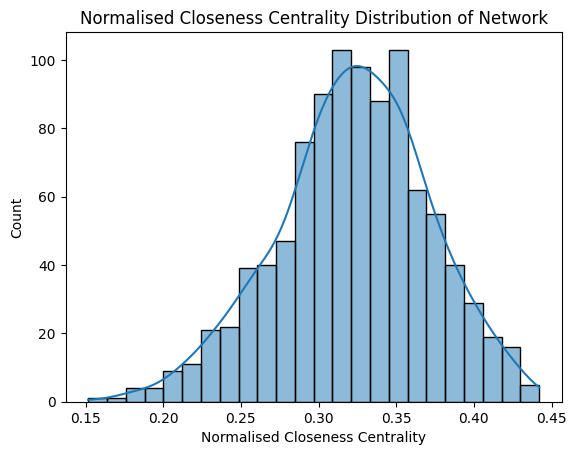

Clustering Coefficient Distribution Statistics:
count    983.000000
mean       0.322280
std        0.048840
min        0.151651
25%        0.292908
50%        0.324959
75%        0.354810
max        0.441996
dtype: float64


In [26]:
sns.histplot(data=list(closeness_centrality.values()), kde=True)
plt.title('Normalised Closeness Centrality Distribution of Network')
plt.xlabel('Normalised Closeness Centrality')
plt.show()

print(f"Clustering Coefficient Distribution Statistics:\n{pd.Series(closeness_centrality.values()).describe()}")

### Country Network

In [57]:
country_network = {}
for node, neighbours in tqdm(network.items()):
    node_country = scientists[node]['country']
    for neighbour, weight in neighbours.items():
        neighbour_country = scientists[neighbour]['country']
        if node_country in country_network:
            if neighbour_country in country_network[node_country]:
                country_network[node_country][neighbour_country] += weight
            else:
                country_network[node_country][neighbour_country] = weight
        else:
            country_network[node_country] = {neighbour_country: weight}

100%|██████████| 993/993 [00:00<00:00, 95122.62it/s]


In [58]:
country_network_2 = copy.deepcopy(country_network)
country_network['uae'] = {}

# There are some people with multiple countries so we add their contributions to both countries they are from
for node, neighbours in tqdm(country_network_2.items()):
    if "," not in node:  # Node is one country only
        for neighbour, weight in neighbours.items():
            if "," not in neighbour:  # Neighbour also is one country only
                continue
            else:  # Neighbour is also multiple countries
                neighbour_list = str_to_list(neighbour)
                for neighbour2 in neighbour_list:
                    if neighbour2 in country_network[node]:
                        country_network[node][neighbour2] += weight
                    else:
                        country_network[node][neighbour2] = weight
                country_network[node].pop(neighbour, None)
    else:  # Node is multiple countries
        node_list = str_to_list(node)
        for node2 in node_list:
            for neighbour, weight in neighbours.items():
                if "," not in neighbour:  # Neighbour is one country only
                    if neighbour in country_network[node2]:
                        country_network[node2][neighbour] += weight
                    else:
                        country_network[node2][neighbour] = weight
                else:  # Neighbour is also multiple countries
                    neighbour_list = str_to_list(neighbour)
                    for neighbour2 in neighbour_list:
                        if neighbour2 in country_network[node2]:
                            country_network[node2][neighbour2] += weight
                        else:
                            country_network[node2][neighbour2] = weight
                    country_network[node2].pop(neighbour, None)
        country_network.pop(node, None)

100%|██████████| 60/60 [00:00<00:00, 126081.28it/s]


In [63]:
degree_dict = {node: len(vals) for node, vals in country_network.items()}
degree_distribution = list(degree_dict.values())
print(f"Degree Distribution Statistics:\n{pd.Series(degree_distribution).describe()}")

Degree Distribution Statistics:
count    43.000000
mean     18.534884
std      10.724580
min       1.000000
25%      10.000000
50%      16.000000
75%      27.000000
max      41.000000
dtype: float64


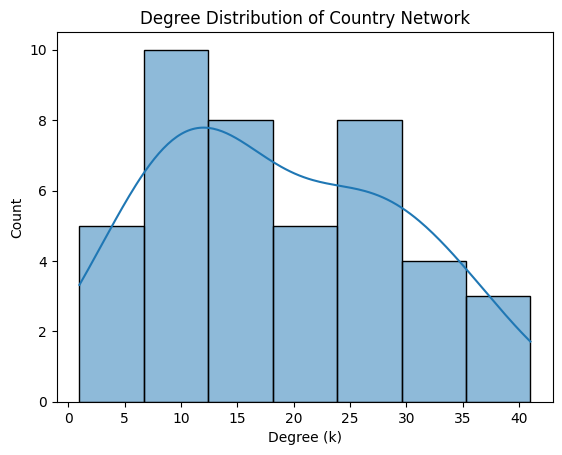

In [64]:
sns.histplot(data=degree_distribution, kde=True)
plt.title('Degree Distribution of Country Network')
plt.xlabel('Degree (k)')
plt.show()

In [66]:
# Create pandas edge list
temp_df_list = []
for node, neighbours in tqdm(country_network.items()):
    for neighbour, weight in neighbours.items():
        temp_df_list.append({
            'Source': node,
            'Destination': neighbour,
            'Weight': weight
        })

df_country_network_edgelist = pd.DataFrame(temp_df_list) 

country_G = nx.from_pandas_edgelist(df_country_network_edgelist, source='Source', target='Destination', edge_attr='Weight')

100%|██████████| 43/43 [00:00<00:00, 84634.01it/s]


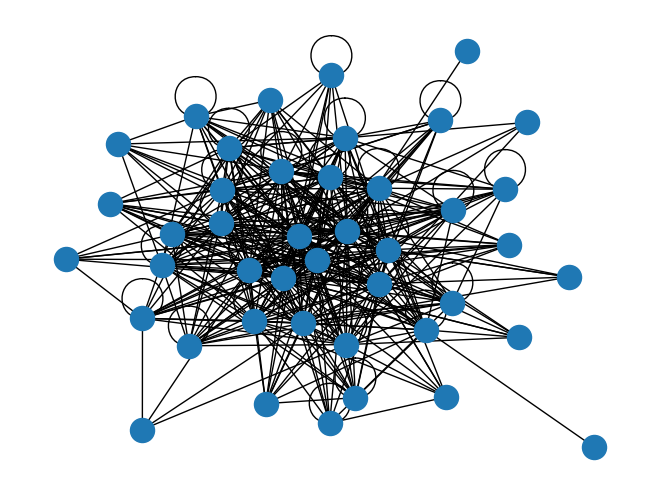

In [75]:
nx.draw_kamada_kawai(country_G)

In [70]:
net = Network(notebook=True)
net.from_nx(country_G)
net.show_buttons(filter_=['physics'])
net.show("country_network.html")

country_network.html
